# Распознавание рукописных цифр при помощи свёрточной нейронной сети

In [ ]:
##WRITE YOUR CODE HERE
import torch
import random
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Загрузим набор данных MNIST:

In [ ]:
from torchvision import datasets

In [ ]:
MNIST_train = datasets.MNIST('./', train=True, download=True)
MNIST_test = datasets.MNIST('./', train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35450139.79it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1100253.35it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9348313.12it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4946904.38it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Разделим данные на тестовые и тренировочные множества:

In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

Посмотрим на количество элементов в `y_train` и `y_test`.

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

Выведем на экран одно из изображений:

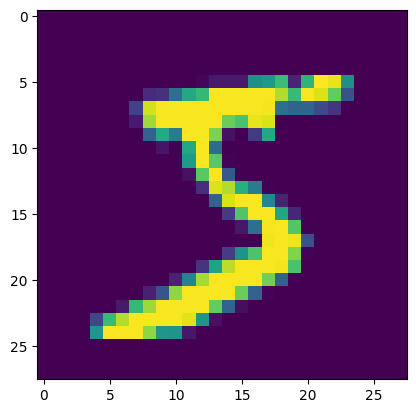

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Добавим ещё одну единичную размерность на место 1 и переведём данные в тип float:

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

Посмторим на получившиеся размерности `X_train` и `X_test`:

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Создадим класс для нейронной сети:
- первый свёрточный слой содержит 6 свёрток размера $5 times 5$ со сдвигом 2, с последующей функцией активации тангенс и average pooling размерностью $2 \times 2$;
- второй свёрточный слой содержит 16 свёрток размера $5 times 5$ без сдвига, с последующей функцией активации тангенс и average pooling размерностью $2 \times 2$;
- после них идёт полносвязный слой с функцией активации тангенс;
- в завершение расположен полносвязный выходной слой.

In [ ]:
class CAP(nn.Module):

  def __init__(self, in_c, out_c, stride=1):
    super(CAP, self).__init__()

    self.cap_seq = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=5, stride=stride),
        nn.Tanh(),
        nn.AvgPool2d(2)
    )

  def forward(self, x):
    x = self.cap_seq(x)

    return x

In [ ]:
class LeNet5(torch.nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()

        self.cap1 = CAP(1, 6, 2)

        self.cap2 = CAP(6, 16)

        self.flat = nn.Flatten()

        self.fc1   = nn.Linear(16, 32) # 16 x 1 x 1
        self.act3  = nn.Tanh()

        self.fc2   = nn.Linear(32, 16)
        self.act4  = nn.Tanh()

        self.fc3   = nn.Linear(16, 10)

    def forward(self, x):

        x = self.cap1(x)
        x = self.cap2(x)
        # x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.flat(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)

        return x

Создадим экземпляр класса:

In [ ]:
lenet5 = LeNet5()

Определим устрйоство, на котором будем обучать модель:



In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # Определение устройства (GPU или CPU)
lenet5 = lenet5.to(device)  # Перенос модели на указанное устройство

Определим функцию потерь через кросс-энтропию, а в качестве оптимизатора возьмём Adam с шагом обучения 0,001.

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

Обучим нашу нейронную сеть:

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)  # Перенос тестового набора данных на устройство
y_test = y_test.to(device)  # Перенос меток тестового набора данных на устройство

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        lenet5.train()  # Перевод модели в режим обучения

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)  # Выделение и перенос батча на устройство
        y_batch = y_train[batch_indexes].to(device)  # Выделение и перенос меток батча на устройство

        optimizer.zero_grad()  # Обнуление градиентов

        preds = lenet5(X_batch)  # Получение предсказаний модели

        loss_value = loss(preds, y_batch)  # Вычисление значения функции потерь
        loss_value.backward()  # Расчет градиентов
        optimizer.step()  # Шаг оптимизатора

    with torch.no_grad():
        lenet5.eval()  # Перевод модели в режим оценки (evaluation)

        test_preds = lenet5(X_test)  # Получение предсказаний на тестовом наборе данных
        test_loss_history.append(loss(test_preds, y_test).item())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()  # Вычисление точности
        test_accuracy_history.append(accuracy)

        print(f"Точность на тесте после эпохи {epoch + 1}: {accuracy}")

# После завершения обучения модели
print("Обучение завершено.")

Точность на тесте после эпохи 1: 0.7500999569892883
Точность на тесте после эпохи 2: 0.847599983215332
Точность на тесте после эпохи 3: 0.8884999752044678
Точность на тесте после эпохи 4: 0.9407999515533447
Точность на тесте после эпохи 5: 0.9520999789237976
Точность на тесте после эпохи 6: 0.9574999809265137
Точность на тесте после эпохи 7: 0.9601999521255493
Точность на тесте после эпохи 8: 0.9645999670028687
Точность на тесте после эпохи 9: 0.9598999619483948
Точность на тесте после эпохи 10: 0.9668999910354614
Обучение завершено.


Выведем на экран значения точности и потерь:

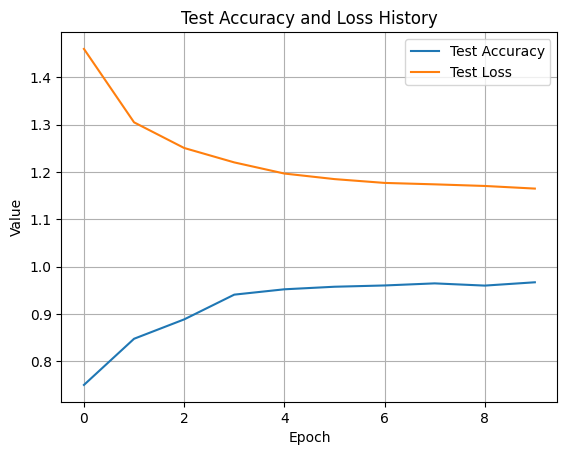

In [ ]:
# Построение графика
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Test Accuracy and Loss History')
plt.legend()
plt.grid(True)
plt.show()